# Digital Tools for Finance - Project
**Research Question:**\
What is the effect of the U.S. GDP growth rate on different S&P500 sector indices' market capitalizations\

**Authors:**\
Jonas Neller, 21-730-676\
Lorena Tassone, 18-700-237\
Naomi Huser, 17-056-201

## ToDo List:

Up- and downstream functions for database\
<s>Data cleaning</s> -> NaN values?\
<s>Regressions</s>  -> which value to regress?\
plots

create docker container for jupyter-notebook and app


--> interactive app -> Use ipywidget for app of Jupyter Notebook! \
--> good comments in code and github commits! \
--> Fore presentation use beamer!




## Inputs
If you want to use your own local data, create and input your environmental variable leading to the data and set 'envvar'=1. Otherwise set 'envvar'=0 and the dataset in the github repository will be used (suggested method).\

Input start and end date for the data (quarterly).

In [1]:
### Input ###

# envvar = 1: if want to use own ENVIRONMENTAL VARIABLE (Attention: need to redefine env_var)
# envvar = 0: if want to use data in github repository
envvar = 0
env_var = "RESEARCH_DATA_PATH"

# start and end date of macro factors data (quarterly, first day of month)
start_date_macro = "2007-01-01"
end_date_macro = "2021-01-01"

# start and end date of S&P500 mcap data (quarterly, last day of month)
start_date_sp500 = "2006-12-29"
end_date_sp500 = "2020-12-31"

## Data Cleaning

In [2]:
# libraries
import numpy as np
import pandas as pd
import os
from functools import reduce
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../data/interim')
from downstream import get_macro_data, get_SP500_mcap_data

In [3]:
# set variable according to environmental variable path or github path
if envvar == 1:
    path = os.environ.get(env_var)
else:
    path = os.path.join('..','data','processed')


In [4]:
# get mcap data
data_mcap = get_SP500_mcap_data(path) # later changed to mio.

# get macro data for each factor
data_gdp = get_macro_data(path,"Real_GDP", start_date_macro, end_date_macro) # in bio.
data_gdp = data_gdp[['Real_GDP']]
data_gdp['Real_GDP'] = data_gdp['Real_GDP'] * 1000 # now in mio
data_unempr = get_macro_data(path,'Unemployment_rate', start_date_macro, end_date_macro)
data_crudeprice = get_macro_data(path,'Crude_price', start_date_macro, end_date_macro)
data_feddebt = get_macro_data(path,'Federal_debt', start_date_macro, end_date_macro) # in mio.
data_feddebt = data_feddebt[['Federal_debt']]
data_fedrate = get_macro_data(path,'Federal_rate', start_date_macro, end_date_macro)

# merge factors by quarterly date
data_frames = [data_gdp, data_unempr, data_crudeprice, data_feddebt, data_fedrate]
data_factors_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date '], how='inner'), data_frames)
data_factors_merged.index = pd.to_datetime(data_factors_merged.index).date
n_factors = len(data_factors_merged.columns)
data_factors_merged



,Real_GDP,Unemployment_rate,Crude_price,Federal_debt,Federal_rate
2007-01-01,15478956.0,4.6,54.780000,8849665,5.25
2007-04-01,15577779.0,4.5,63.974762,8867677,5.25
2007-07-01,15671605.0,4.7,74.046364,9007653,5.26
2007-10-01,15767146.0,4.7,85.926522,9229172,4.76
2008-01-01,15702906.0,5.0,92.982609,9437594,3.94
2008-04-01,15792773.0,5.0,112.336364,9492006,2.28
2008-07-01,15709562.0,5.8,133.958261,10024725,2.01
2008-10-01,15366607.0,6.5,76.283913,10699805,0.97
2009-01-01,15187475.0,7.8,41.630909,11126941,0.15
2009-04-01,15161772.0,9.0,49.905909,11545275,0.15


In [5]:
# create subsectors
data_mcap.columns = data_mcap.loc['Sector',:]
sectors = data_mcap.loc['Sector',:].unique()
print(sectors)

start = 0
end = 0

communication = data_mcap[['Communication Services']].tail(-3)
communication.index = pd.to_datetime(communication.index).date


# get index of start and end date (since .loc doesn't work)
for idx, date in enumerate(communication.index):
    if str(date) == start_date_sp500:
        start = idx
        print(start)
    if str(date) == end_date_sp500:
        end = idx
        print(end)
        
communication = communication.iloc[start:end+1,:]

consumerdisc = data_mcap[['Consumer Discretionary']].tail(-3)
consumerdisc.index = pd.to_datetime(consumerdisc.index).date
consumerdisc = consumerdisc.iloc[start:end+1,:]

consumerstap = data_mcap[['Consumer Staples']].tail(-3)
consumerstap.index = pd.to_datetime(consumerstap.index).date
consumerstap = consumerstap.iloc[start:end+1,:]

energy = data_mcap[['Energy']].tail(-3)
energy.index = pd.to_datetime(energy.index).date
energy = energy.iloc[start:end+1,:]

financials = data_mcap[['Financials']].tail(-3)
financials.index = pd.to_datetime(financials.index).date
financials = financials.iloc[start:end+1,:]

healthcare = data_mcap[['Health Care']].tail(-3)
healthcare.index = pd.to_datetime(healthcare.index).date
healthcare = healthcare.iloc[start:end+1,:]

industrials = data_mcap[['Industrials']].tail(-3)
industrials.index = pd.to_datetime(industrials.index).date
industrials = industrials.iloc[start:end+1,:]

informationtech = data_mcap[['Information Technology']].tail(-3)
informationtech.index = pd.to_datetime(informationtech.index).date
informationtech = informationtech.iloc[start:end+1,:]

materials = data_mcap[['Materials']].tail(-3)
materials.index = pd.to_datetime(materials.index).date
materials = materials.iloc[start:end+1,:]

realestate = data_mcap[['Real Estate']].tail(-3)
realestate.index = pd.to_datetime(realestate.index).date
realestate = realestate.iloc[start:end+1,:]

utilities = data_mcap[['Utilities']].tail(-3)
utilities.index = pd.to_datetime(utilities.index).date
utilities = utilities.iloc[start:end+1,:]

utilities

['Communication Services' 'Consumer Discretionary' 'Consumer Staples'
 'Energy' 'Financials' 'Health Care' 'Industrials'
 'Information Technology' 'Materials' 'Real Estate' 'Utilities']
0
56


Sector,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,...,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities,Utilities
2006-12-29,14638712578.440001,4384709584.45254,11082465319.5,16843471727.5,NaN,2783812955.56,5186872195.1,3714659289.6,12344091521.74,NaN,...,2585436457.09001,7082069181.42,16509186008.719999,5042522737.47,12668866168.236,16741258572.139999,14692202603.76,27377404804.080002,5551817787.18,9382708997.219999
2007-03-30,14293334604.719999,5203142483.98959,10374986145.0,19337893380.0,NaN,2770689248.16,5742217475.28,3973954379.2,13155459853.74,NaN,...,2630056060.93063,8813046970.639999,16933949864.25,4799797239.75,14457495295.370501,20942966433.119999,16040666104.379999,27435978163.0,5674427245.96,10067390534.67
2007-06-29,14619747943.040001,4510086514.57497,10170069510.9,17960461536.32,NaN,2669515424.1,5581703213.4,3840000860.8,12205768099.200001,NaN,...,2230398860.43326,10073112452.18,15922900532.4,3964184870.55,16710462345.6555,22263327147.599998,15625445214.120001,25779517271.189999,5172710574.79,8370499773.25
2007-09-28,13399013097.120001,4448559078.15501,10899085680.0,18395319997.439999,NaN,2525014003.68,5148532071.2,3777497632.16,12546154676.9,NaN,...,2062030361.8079,10142537781.450001,16890508337.0,3963216017.88,16457065022.064199,22374390646.650002,15345081970.639999,27443191550.279999,5266183705.17,9044078162.52
2007-12-31,14315413925.07,4723691869.76736,11276176509.389999,18643867338.240002,NaN,2516583130.2,5503085216.85,3903264497.44,13237141597.549999,NaN,...,2035175796.14,10343243513.459999,15256086158.67,4257329376.76,17988112199.596802,24983726704.959999,16176116207.16,29429803538.75,5696297037.12,9477821860.459999
2008-03-31,11189927437.98,3866971305.3726,9197420441.040001,16669763687.52,NaN,2288618752.5,4684342634.52,3048897541.34,10803922468.5,NaN,...,1857445107.65951,9218884263.26,13123393899.559999,3521507062.88,15877949067.0611,20441693328.02,13922387942.4,27231399981.990002,5143660652.47,8561502181.05
2008-06-30,12905493651.459999,3783440279.20662,8819415649.98,16156006131.15,3548800000.0,2486498185.65,5268654469.8,3355138357.9,10657320170.49,NaN,...,1930919693.56965,10121052813.299999,14179609590.93,3088847557.72,18091052073.992401,23361208622.939999,14131787158.6,26894940376.32,5287119732.02,8647303241.34
2008-09-30,7864423441.98,3557519311.06662,8204430690.57,14895645178.469999,3439156447.5,2412504635.64,4980371192.44,2812043122.67,11736279603.360001,NaN,...,1590548581.5726,5840619072.75,13427923772.9,3466242143.7,12862862454.927401,16677858278.82,12434716283.43,29193933806.09,5249662920.4,8615777616.17
2008-12-31,5456734733.36,3222862738.16238,7061098000.0,13514051399.68,3340462662.72,2169898790.7,4343307958.28,2286958674.24,10652401729.48,NaN,...,1182276792.65724,5467542207.61,13973688046.43,3239171909.19,10665887122.8118,14762794154.51,10385975973.66,28786000000.0,4908259452.08,8329858931.45
2009-03-31,3870715012.29,2731559807.36888,4923237000.0,10257359926.559999,3078393554.6,2125054986.16,3623423959.89,2685414262.08,10863193295.27,NaN,...,1056350055.12094,4668799256.0,14018252981.459999,2682315090.24,9997485220.75008,14911704860.709999,11255996044.799999,23971335026.700001,4813349709.36,8481319013.34


In [6]:
# check if correct time series for macro factors and mcap data are selected
# otherwise we regress wrong values!
diff = communication.index - data_factors_merged.index
print(diff)

if all(d.days > -5 for d in diff): # because measurement lag of ~3 days
    pass
else:
    sys.exit("Time series of macro factors and market cap do not coincide. Re-set start and end date!")



TimedeltaIndex(['-3 days', '-2 days', '-2 days', '-3 days', '-1 days',
                '-1 days', '-1 days', '-1 days', '-1 days', '-1 days',
                '-1 days', '-1 days', '-1 days', '-1 days', '-1 days',
                '-1 days', '-1 days', '-1 days', '-1 days', '-1 days',
                '-2 days', '-2 days', '-2 days', '-3 days', '-1 days',
                '-4 days', '-3 days', '-1 days', '-1 days', '-1 days',
                '-1 days', '-1 days', '-1 days', '-1 days', '-1 days',
                '-1 days', '-1 days', '-1 days', '-1 days', '-1 days',
                '-2 days', '-1 days', '-1 days', '-2 days', '-3 days',
                '-3 days', '-2 days', '-3 days', '-1 days', '-3 days',
                '-3 days', '-1 days', '-1 days', '-1 days', '-1 days',
                '-1 days', '-1 days'],
               dtype='timedelta64[ns]', freq=None)


In [7]:
# checking timeframe length
print(len(utilities.index))
print(len(data_factors_merged))

57
57


In [8]:
# Manipulate data
print(communication.shape)
communication = communication.dropna(axis=1) # Drop Companies with missing Market Cap Data
communication.columns = np.arange(len(communication.columns)) # reset column names
communication = communication.set_index(data_factors_merged.index) # set identical index as factor data
communication = communication/1000000 # mcap in millions
print(communication.shape)

print(consumerdisc.shape)
consumerdisc = consumerdisc.dropna(axis=1)
consumerdisc.columns = np.arange(len(consumerdisc.columns))
consumerdisc = consumerdisc.set_index(data_factors_merged.index)
consumerdisc = consumerdisc/1000000
print(consumerdisc.shape)

print(consumerstap.shape)
consumerstap = consumerstap.dropna(axis=1)
consumerstap.columns = np.arange(len(consumerstap.columns))
consumerstap = consumerstap.set_index(data_factors_merged.index)
consumerstap = consumerstap/1000000
print(consumerstap.shape)

print(energy.shape)
energy = energy.dropna(axis=1)
energy.columns = np.arange(len(energy.columns))
energy = energy.set_index(data_factors_merged.index)
energy = energy/1000000
print(energy.shape)

print(financials.shape)
financials = financials.dropna(axis=1)
financials.columns = np.arange(len(financials.columns))
financials = financials.set_index(data_factors_merged.index)
financials = financials/1000000
print(financials.shape)

print(healthcare.shape)
healthcare = healthcare.dropna(axis=1)
healthcare.columns = np.arange(len(healthcare.columns))
healthcare = healthcare.set_index(data_factors_merged.index)
healthcare = healthcare/1000000
print(healthcare.shape)

print(industrials.shape)
industrials = industrials.dropna(axis=1)
industrials.columns = np.arange(len(industrials.columns))
industrials = industrials.set_index(data_factors_merged.index)
industrials = industrials/1000000
print(industrials.shape)

print(informationtech.shape)
informationtech = informationtech.dropna(axis=1)
informationtech.columns = np.arange(len(informationtech.columns))
informationtech = informationtech.set_index(data_factors_merged.index)
informationtech = informationtech/1000000
print(informationtech.shape)

print(materials.shape)
materials = materials.dropna(axis=1)
materials.columns = np.arange(len(materials.columns))
materials = materials.set_index(data_factors_merged.index)
materials = materials/1000000
print(materials.shape)

print(realestate.shape)
realestate = realestate.dropna(axis=1)
realestate.columns = np.arange(len(realestate.columns))
realestate = realestate.set_index(data_factors_merged.index)
realestate = realestate/1000000
print(realestate.shape)

print(utilities.shape)
utilities = utilities.dropna(axis=1)
utilities.columns = np.arange(len(utilities.columns))
utilities = utilities.set_index(data_factors_merged.index)
utilities = utilities/1000000
print(utilities.shape)

communication

(57, 25)
(57, 17)
(57, 56)
(57, 47)
(57, 33)
(57, 29)
(57, 23)
(57, 18)
(57, 67)
(57, 61)
(57, 64)
(57, 56)
(57, 71)
(57, 59)
(57, 75)
(57, 55)
(57, 28)
(57, 22)
(57, 31)
(57, 29)
(57, 30)
(57, 28)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2007-01-01,4833.603074,70557.981608,70557.981608,103749.051729,57919.168661,15233.507136,15535.809106,5400.076627,1466.700144,5011.59457,1770.355057,17865.886,26309.657435,1288.467096,101153.865241,69892.560966,2090.015928
2007-04-01,5310.234468,71303.169607,71303.169607,185929.510507,53466.289062,17440.105537,15613.75702,5769.832065,1445.685776,5033.003081,1594.334496,17107.698,24015.772763,1468.746759,102312.4263,69538.88938,2485.616704
2007-07-01,5289.411404,81501.943219,81501.943219,193227.583379,58169.368962,17441.709404,14738.906335,5345.321729,1466.377974,5372.163629,1323.557277,17505.936,24409.191351,1469.669844,111210.135408,67652.826248,2988.438376
2007-10-01,6163.482218,88618.335842,88618.335842,194871.509447,50138.767292,18855.02795,17465.429504,4893.793704,1401.984624,5001.845112,1395.887801,15787.947,23040.650491,1264.594711,119577.080018,66748.36257,3753.005757
2008-01-01,8651.913178,108266.383469,108266.383469,190343.401291,37498.095238,15229.519577,18397.636655,3822.898556,1087.446433,4576.472215,1750.982304,15537.557,18637.63412,1371.41171,117487.35519,61444.486471,3277.853831
2008-04-01,8026.776975,69083.943397,69083.943397,174572.971042,39378.461122,12887.491656,15813.628397,3962.38869,908.999675,3532.718314,2120.225577,14164.108,15031.423207,1961.600823,96671.884034,59088.710613,2769.676603
2008-07-01,10110.229367,82752.571391,82752.571391,151150.405133,39056.803813,13154.155647,14147.316805,4058.733493,801.651848,3752.904285,1608.209919,14375.064,13272.461299,1974.860774,94230.055041,59441.671973,2867.120419
2008-10-01,20343.505839,63032.128239,63032.128239,124251.206006,40440.203085,9450.200039,11793.227408,3692.657551,1232.78597,3751.151139,1879.606149,12292.928,10770.182007,1272.683099,85201.888575,57587.477542,2086.723945
2009-01-01,11442.736002,48464.019041,48464.019041,126832.357685,34789.38855,4957.868199,5146.930727,1887.098693,448.820479,2738.740612,1759.399579,8366.736,5568.714636,587.24249,90023.946015,41999.806283,2902.912156
2009-04-01,13673.470208,54995.150823,54995.150823,112146.50078,28148.59164,4970.791827,5853.904017,1962.855089,209.058888,2827.168097,2510.605818,7275.8088,2612.328179,670.655943,80186.294146,33711.036554,3214.226843


In [9]:
# take average mcap of each sector
data_factors_merged['mean_communication'] = communication.mean(axis=1)
data_factors_merged['mean_consumerdisc'] = consumerdisc.mean(axis=1)
data_factors_merged['mean_consumerstap'] = consumerstap.mean(axis=1)
data_factors_merged['mean_energy'] = energy.mean(axis=1)
data_factors_merged['mean_financials'] = financials.mean(axis=1)
data_factors_merged['mean_healthcare'] = healthcare.mean(axis=1)
data_factors_merged['mean_industrials'] = industrials.mean(axis=1)
data_factors_merged['mean_informationtech'] = informationtech.mean(axis=1)
data_factors_merged['mean_materials'] = materials.mean(axis=1)
data_factors_merged['mean_realestate'] = realestate.mean(axis=1)
data_factors_merged['mean_utilities'] = utilities.mean(axis=1)
data_factors_merged



,Real_GDP,Unemployment_rate,Crude_price,Federal_debt,Federal_rate,mean_communication,mean_consumerdisc,mean_consumerstap,mean_energy,mean_financials,mean_healthcare,mean_industrials,mean_informationtech,mean_materials,mean_realestate,mean_utilities
2007-01-01,15478956.0,4.6,54.780000,8849665,5.25,33566.840117,13976.755474,35114.892851,56310.751253,37776.126421,22132.352255,20349.909097,27144.892828,7853.160657,7264.136631,12883.127893
2007-04-01,15577779.0,4.5,63.974762,8867677,5.25,38302.249478,14503.530138,35212.858725,56438.893339,37015.969139,22413.011674,20382.270076,26421.560145,9070.796753,7742.640188,13911.226269
2007-07-01,15671605.0,4.7,74.046364,9007653,5.26,40624.381397,14662.968567,35588.168359,63317.858592,37527.513582,23103.166518,22189.265586,29391.742272,9796.573312,7148.311071,13639.476060
2007-10-01,15767146.0,4.7,85.926522,9229172,4.76,41623.296464,15037.524626,36732.824113,69278.232520,37453.745195,23375.133972,23358.406261,31306.212811,10566.540863,7338.628824,13798.571143
2008-01-01,15702906.0,5.0,92.982609,9437594,3.94,42096.907689,13285.795094,37801.508990,70566.237756,35004.099575,23350.162683,21849.902373,31631.543364,11177.673054,6721.944800,14455.568098
2008-04-01,15792773.0,5.0,112.336364,9492006,2.28,34650.526560,12018.632715,37128.022826,63541.830952,31040.045174,20347.138196,20693.358493,26651.761460,10757.432186,6579.862658,12858.594423
2008-07-01,15709562.0,5.8,133.958261,10024725,2.01,34676.869800,10568.747299,34485.101579,71802.664608,26359.737511,19646.907437,18369.901164,27269.837431,12293.842884,6345.412886,13743.757261
2008-10-01,15366607.0,6.5,76.283913,10699805,0.97,30124.157814,10736.198514,36335.700442,56421.450117,29074.541413,19459.001754,16690.777128,24108.561465,8464.278004,6663.310598,11613.945559
2009-01-01,15187475.0,7.8,41.630909,11126941,0.15,25669.455070,8256.185435,31451.094681,47308.732096,19784.217875,16791.544394,12571.210003,17901.993943,6054.703379,4424.134370,10315.682971
2009-04-01,15161772.0,9.0,49.905909,11545275,0.15,24115.505793,8070.414149,28089.438553,40462.398036,15437.949787,14908.839618,9794.054700,18646.924523,6193.916437,3399.104884,9275.650933


## Regression

In [10]:
# Regress mean market cap on GDP growth and controlling variables for all sectors
list_of_sectors = ["mean_communication","mean_consumerdisc","mean_consumerstap","mean_energy","mean_financials","mean_healthcare","mean_industrials","mean_informationtech","mean_materials","mean_realestate","mean_utilities"]

# regressions & output
models = []

for resp in list_of_sectors:
    formula = resp + " ~ Real_GDP + Unemployment_rate + Crude_price + Federal_debt + Federal_rate"
    res = smf.ols(formula, data = data_factors_merged).fit()
    models.append(res)

regoutputs = summary_col(models,stars=True)
print(regoutputs)

# latex table for paper
regoutputs.as_latex()
    


                  mean_communication mean_consumerdisc mean_consumerstap  mean_energy  mean_financials mean_healthcare mean_industrials mean_informationtech mean_materials mean_realestate mean_utilities
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept         -426623.1333***    -101575.6982*     63161.7972*       140636.6070*  -61152.2646     -40738.0436     13095.0883       -100640.4068         -12439.7112    -29193.6376**   -24398.8806   
                  (131825.8134)      (53595.7324)      (33392.2623)      (75401.6600)  (49080.7712)    (35376.8140)    (23911.5315)     (139211.1836)        (14591.7968)   (12536.1712)    (16485.3283)  
Real_GDP          0.0260***          0.0049            -0.0031           -0.0054       0.0053          0.0025          -0.0006          0.0008               0.0007         0.0019**       

'\\begin{table}\n\\caption{}\n\\label{}\n\\begin{center}\n\\begin{tabular}{llllllllllll}\n\\hline\n                   & mean\\_communication & mean\\_consumerdisc & mean\\_consumerstap & mean\\_energy  & mean\\_financials & mean\\_healthcare & mean\\_industrials & mean\\_informationtech & mean\\_materials & mean\\_realestate & mean\\_utilities  \\\\\n\\hline\nIntercept          & -426623.1333***     & -101575.6982*      & 63161.7972*        & 140636.6070*  & -61152.2646      & -40738.0436      & 13095.0883        & -100640.4068          & -12439.7112     & -29193.6376**    & -24398.8806      \\\\\n                   & (131825.8134)       & (53595.7324)       & (33392.2623)       & (75401.6600)  & (49080.7712)     & (35376.8140)     & (23911.5315)      & (139211.1836)         & (14591.7968)    & (12536.1712)     & (16485.3283)     \\\\\nReal\\_GDP          & 0.0260***           & 0.0049             & -0.0031            & -0.0054       & 0.0053           & 0.0025           & -0.0006     

### Plotting

mean_communication


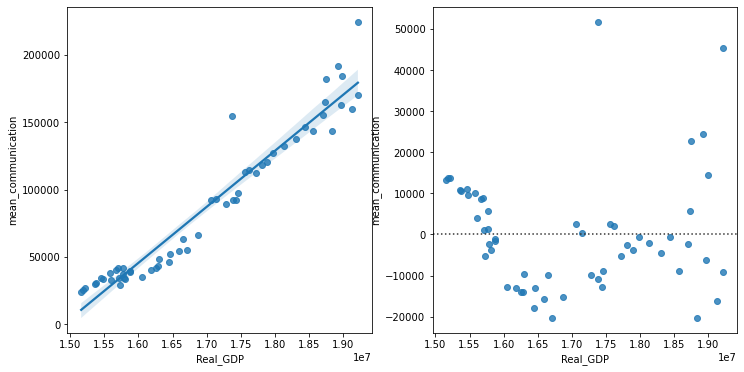

mean_consumerdisc


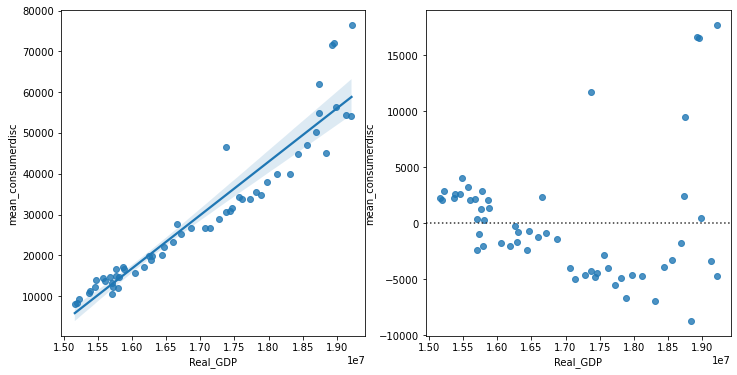

mean_consumerstap


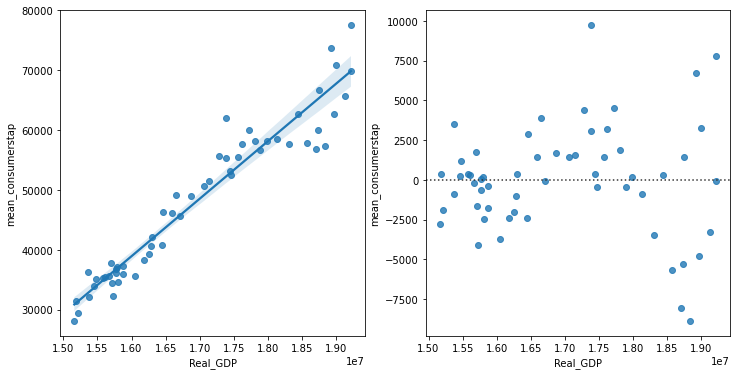

mean_energy


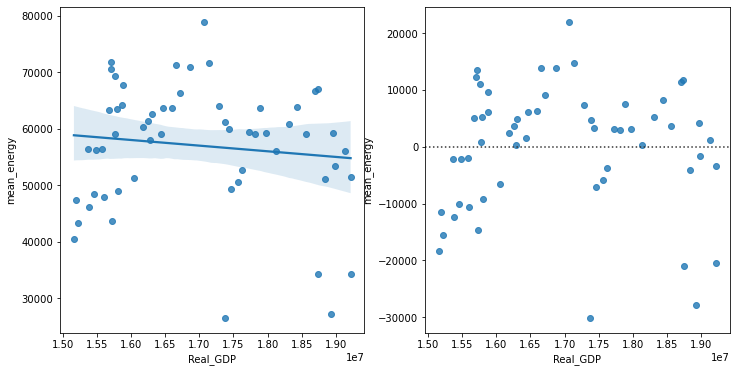

mean_financials


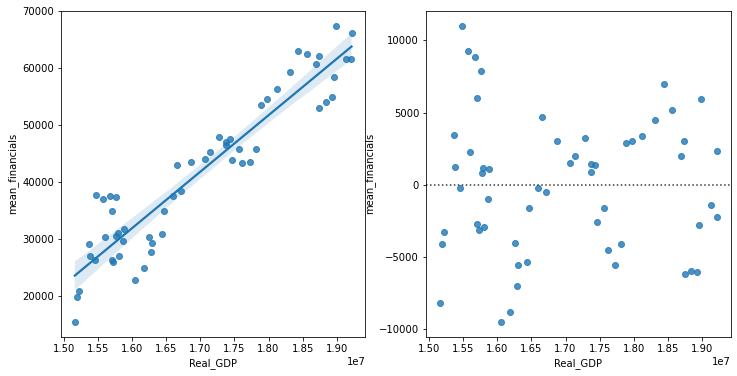

mean_healthcare


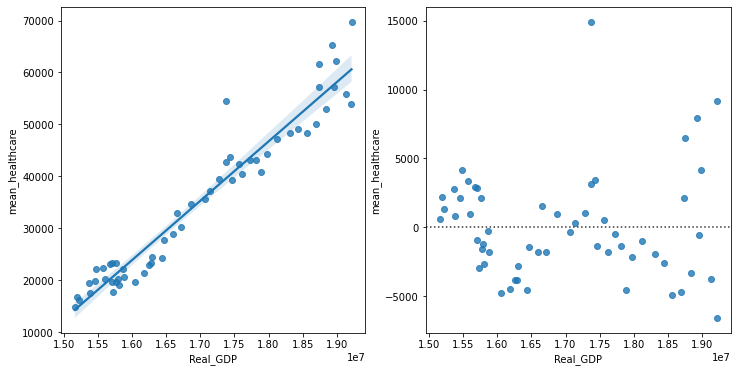

mean_industrials


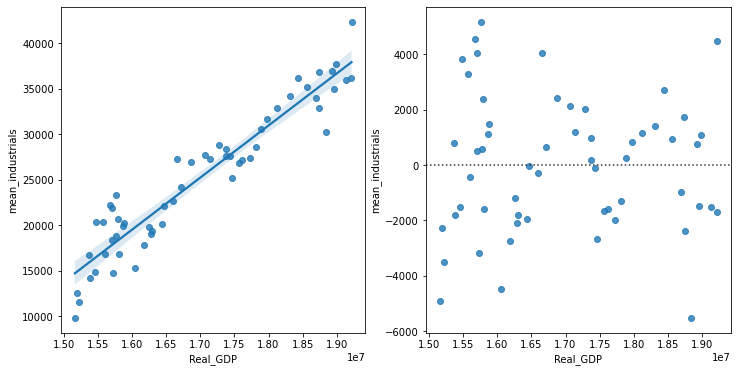

mean_informationtech


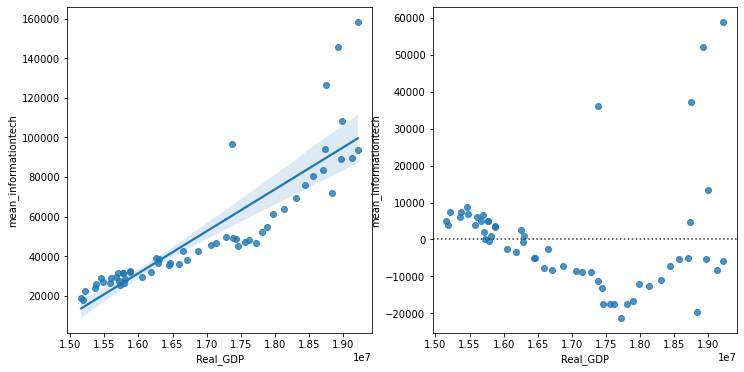

mean_materials


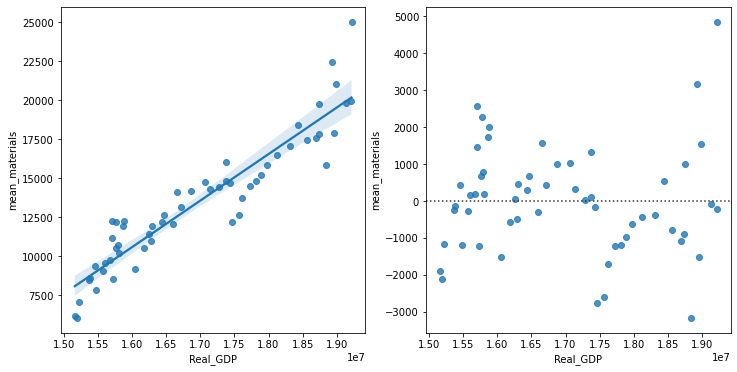

mean_realestate


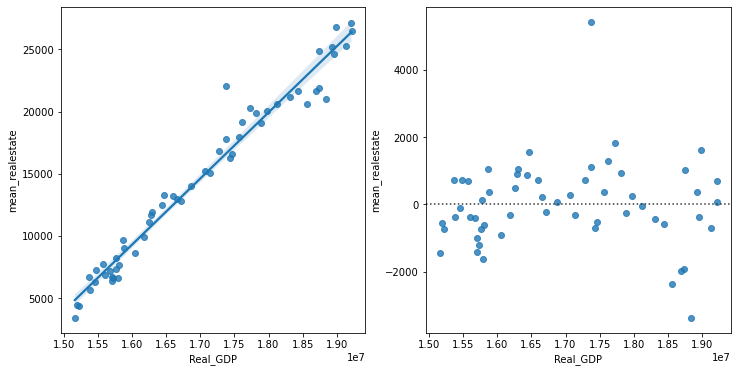

mean_utilities


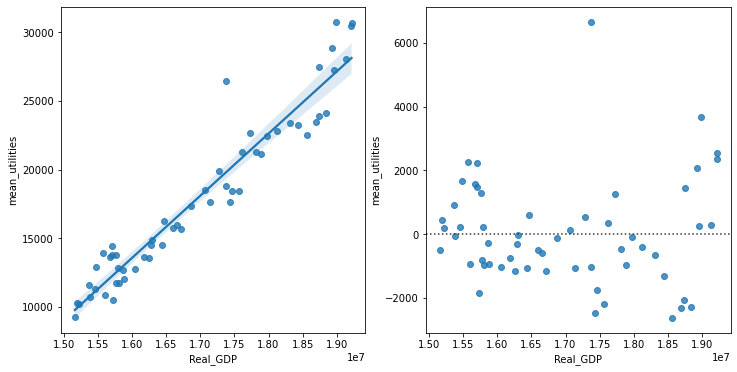

In [11]:
# regression plot

for s in range(len(sectors)):
    sector = data_factors_merged.columns[n_factors+s]
    print(sector)

    fig, [ax0, ax1] = plt.subplots(1,2)
    fig.set_size_inches([12,6])
    sns.regplot(data=data_factors_merged, x='Real_GDP', y=sector, ax=ax0)
    sns.residplot(data=data_factors_merged, x='Real_GDP', y=sector, ax=ax1)
    plt.show()


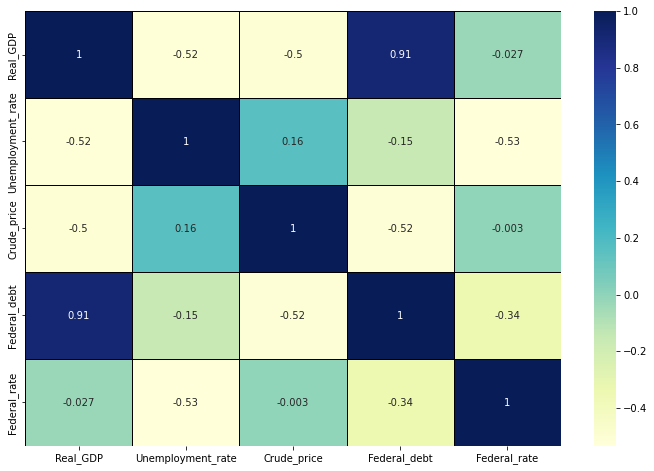

In [12]:
# heatmap

fig, ax = plt.subplots()
fig.set_size_inches([12,8])
sns.heatmap(data_factors_merged.iloc[:,:n_factors].corr(), annot=True, cmap="YlGnBu", linecolor="k", linewidth=0.5)
plt.show()


In [20]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
from chart_studio import pyplot as ply

@interact
def scatter_plot(x=list(data_factors_merged.select_dtypes('number').columns), 
                 y=list(data_factors_merged.select_dtypes('number').columns)[1:],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    
    data_factors_merged.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='title',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)


ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 
